<h2><a>1. Introduction</a></h2>

Our current data science project deals with predicting the Yelp star rating of a review for a business/restaurant based on the text content in the review by employing techniques from Machine Learning.  

The figure below summarizes the workflow of our entire data science pipeline:
<img src="workflow.png" width="600" height="400"></img>
   - <b>Step 1</b>: Scrape the data for the businesses in the city of Pittsburgh on Yelp using the Yelp API to obtain the review texts, the star ratings, user_id, business_id, etc.
   - <b>Step 2</b>: Once we have the dataset, we perform data exploration and visualization to see any interesting trends or patterns in the dataset in terms of feature correlation to the star ratings to identify important features, redundant features to exclude them (as the information carried by them about the task has already been handled by some other feature), etc.
   - <b>Step 3</b>: Once we have an intuition of what features might actually be influencing the Yelp review star rating, we perform feature engineering to extract the feature set and feed them to the machine learning models to facilitate our learning process. We use 3-feature sets and then analyse them by incoporating incrementally to evaluate the final performance of the model. 
   - <b>Step 4</b>: We pose this problem as a 'Multi-Class Classification' problem where each class is a star rating(on a scale of 1-5)i.e star rating=1 is treated as one class, star rating=2 as another class, etc.
   - <b>Step 5</b>: Once we have the results from the ML techniques, we perform some analysis to understand better about which features performed the best and which model works the best in our setting.

<h2><a>2. Tutorial Content</a></h2>

In this project, we try to cover the entire data science pipeline, ranging from data scraping and pre-processing(to ensure that it is an intelligible format) to running some ML models for predictions in Python, using 
[NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/) and [scikit-learn](http://scikit-learn.org/stable/).

The following topics will be covered as part of this project:
- [Dataset](#3.-Yelp-Dataset)
    - [Training Set](#3a.-Training-Set)
    - [Development Set](#3b.-Development-Set)
- [Dataset Exploration](#4.-Dataset-Exploration)
- [Yelp Review Rating Prediction](#5.-Yelp-Review-Rating-Prediction)
    - [Feature Engineering](#5a.-Feature-Engineering)
    - [Machine Learning Models](#5b.-Machine-Learning-Models)
    - [Evaluation Metrics](#5c.-Evaluation-Metrics)
- [Results](#6.-Results)
- [References](#7.-References)

<h2><a>3. Yelp Dataset</a></h2>

For this problem, we needed the Yelp review text and their corresponding star ratings. This information was facilitated by the Yelp API and "BeautifulSoup" library to parse the HTML content of the restaurant pages. The scraper code to create the dataset is provided below:
(The documentation links for the other libraries used during the scraping have been provided in the references)

In [65]:
import io, time, json
import requests
import re
from bs4 import BeautifulSoup
import random

def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
def yelp_search(api_key, query):
    """
    Make an authenticated request to the Yelp API.

    Args:
        query (string): Search term

    Returns:
        total (integer): total number of businesses on Yelp corresponding to the query
        businesses (list): list of dicts representing each business
    """
    
    headers = {}
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    url = "https://api.yelp.com/v3/businesses/search"
    url_params = {}
    url_params['location'] = query  
    response = requests.get(url, headers=headers, params=url_params)

    return response.json()['total'],response.json()['businesses']
    
def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
        
    headers = {}
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
    url = "https://api.yelp.com/v3/businesses/search"
    url_params = {}
    businesses = []
    url_params['location'] = query
    url_params['limit'] = 50
    url_params['categories'] = 'restaurants'
    while(True):
        response = requests.get(url, headers=headers, params=url_params)
        offset = 0
        if(response.status_code == 200 and "total" in response.json()):
            for i in range(0,response.json()["total"], 50):
                if(i>950):
                    break
                url_params["offset"] = offset
                while(True):
                    response = requests.get(url, headers=headers, params=url_params)
                    if(response.status_code == 200 and "businesses" in response.json()):                        
                        businesses.extend(response.json()["businesses"])
                        offset += 50
                        sleep_time = random.random()
                        time.sleep(sleep_time)
                        break
                print((i+50)/10, "% done")
            break
        
    return (businesses)

def parse_api_response(data):
    """
    Parse Yelp API results to extract restaurant URLs.
    
    Args:
        data (string): String of properly formatted JSON.

    Returns:
        (list): list of URLs as strings from the input JSON.
    """
    business_id = []
    businesses_url = []
    data = json.loads(data)
    if("businesses" in data):
        businesses = data["businesses"]
        for i in range(len(businesses)):
            if("url" in businesses[i]):
                business_id.append(businesses[i]["id"])
                businesses_url.append(businesses[i]["url"])

    return business_id,businesses_url

def get_ids_and_urls(data):
    business_list = []
    for item in data:
        business_list.append((item['id'],item['url']))
    return business_list

def parse_page(bus_id,html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    soup = BeautifulSoup(html, "html.parser")
    return_list = list()
    review_list = soup.find_all("div", class_="review review--with-sidebar")
    url = ""
    if(len(soup.find_all("a", class_="u-decoration-none next pagination-links_anchor")) > 0):
            url = soup.find_all("a", class_="u-decoration-none next pagination-links_anchor")[0].attrs['href']
    for tag in review_list:
        review_dict = dict()
        attributes = tag.attrs
        data_review_id = attributes["data-review-id"]
        data_signup_object = attributes["data-signup-object"]
        user_id = attributes["data-signup-object"].split(":")[1]
        rating = float(tag.find_all("div", attrs ={'title':re.compile(r".*rating$")})[0].get('title').split()[0])
        date = tag.find_all("span", class_="rating-qualifier")[0].contents[0].strip()
        review_content = tag.find_all("div", class_="review-content")[0]
        review_text = review_content.find_all("p")[0].get_text().strip()
        voting_buttons = tag.find_all("li",class_= "vote-item inline-block")
        votes = {}
        for vote in voting_buttons:
            vote_type = vote.find_all("span", class_="vote-type")[0].get_text().strip()
            vote_count = vote.find_all("span", class_="count")[0].get_text().strip()
            votes[vote_type] = vote_count
    
        review_dict = {'review_id':data_review_id, 
                       'user_id' : user_id, 
                       'stars':rating, 
                       'date':date, 
                       'text':review_text, 
                       'votes':votes,
                       'business_id':bus_id,
                       'type':"review"
                      }
        return_list.append(review_dict)
        
    return return_list, url

def extract_reviews(bus_id,url):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    return_list = list()
    
    while(True):
        time.sleep(0.1)
        r = requests.get(url)
        prev_url = url
        data, url = parse_page(bus_id,r.content)
        return_list.extend(data)
        if(not(len(url) > 0) or prev_url ==  url):
            break
    return return_list
    
api_key = read_api_key(r"yelp_api_key.txt")
data = all_restaurants(api_key, 'Pittsburgh')
business_list = get_ids_and_urls(data)
for item in business_list:
    review = extract_reviews(item[0],item[1])
    filename = "./data/"+item[0]
    print(filename)
    with open(filename, 'w') as outfile:
        json.dump(review, outfile)
        


num_records, data = yelp_search(api_key, 'Pittsburgh')

    


Once we scrape the required data, i.e the reviews corresponding to the businesses in the city of Pittsburgh, we dump them as json objects(something like a python dictionary) and write to a file. The first 2 lines of such a dataset looks as follows, where each line corresponds to each review:

<u>Train example-1:</u><br/>
{"votes": {"funny": 0, "useful": 1, "cool": 2}, "user_id": "ZWdsr06AvPgDzahZQ7hd2g", "review_id": "LXMeyVEIPvSfhr3eH_QXEg", "stars": 4, "date": "2013-10-06", "text": "I have been to Sky Harbor many a times over the last few years. Most recently I was here last week for business travel. Overall I have always had smooth sailing at this airport. I flew Delta on this trip and went out of terminal 3 which was okay, not bad, not great. The food options were not as great as others have reported recently so I do think that the food options are in terminal 3. Security went by pretty fast. Airport employees were fairly nice, no was out right rude which was good.\n\nOverall I have had good trips out of Phoenix Sky Harbor. I do recommend being dropped off or taking a shuttle. Parking on this trip was $75. Ouch.", "type": "review", "business_id": "hW0Ne_HTHEAgGF1rAdmR-g"}

<u>Train example-2:</u><br/>
{"votes": {"funny": 2, "useful": 0, "cool": 0}, "user_id": "tieBlL2rDsjL2VZIBt_l7w", "review_id": "SYXKKK9XWRdNuwcVI82HbA", "stars": 4, "date": "2013-12-14", "text": "Flying to the east coast on a Friday- I had zero line to wait in to check in and to get through TSa security. I have never been to an airport this fast. The few staff I interacted with were all friendly and they had good food choices in the gates to choose from.", "type": "review", "business_id": "hW0Ne_HTHEAgGF1rAdmR-g"}

From the dataset we created, we perform a 80-20 split to form the dev set(or held out data) to report the performance of the models on this set. 

<h3><a>3a. Training Set</a></h3>

The training set is the input to the Yelp Star Prediction system. The format of the data is as follows:

<table>
        <tr>
            <th style="font-size:16px;text-align:center"><b>Yelp Review Text</b></th>
            <th style="font-size:16px;text-align:center"><b>Yelp Star Rating</b></th> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-1</td>
            <td style="font-size:14px;text-align:center">Star Rating-1</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-2</td>
            <td style="font-size:14px;text-align:center">Star Rating-2</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-3</td>
            <td style="font-size:14px;text-align:center">Star Rating-3</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">......</td>
            <td style="font-size:14px;text-align:center">......</td>
        </tr>
    </table>

where the "Rating" values for a review text range from 1-5. 

<h3><a>3b. Development Set</a></h3>

The development set has the same format of the training set, which consists of review text and their corresponding star ratings. 
<table>
        <tr>
            <th style="font-size:16px;text-align:center"><b>Yelp Review Text</b></th>
            <th style="font-size:16px;text-align:center"><b>Yelp Star Rating</b></th> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-1</td>
            <td style="font-size:14px;text-align:center">Star Rating-1</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-2</td>
            <td style="font-size:14px;text-align:center">Star Rating-2</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Review Text-3</td>
            <td style="font-size:14px;text-align:center">Star Rating-3</td>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">......</td>
            <td style="font-size:14px;text-align:center">......</td>
        </tr>
    </table>



<h2><a>4. Dataset Exploration</a></h2>

Before we proceed forward to feature engineering and prediction using Machine Learning, let us explore the dataset a little to understand the useful features, redundant features, etc.

One of the visualizations that were interested in, was to see the distribution of the ratings in our training dataset. This was done to see if there are any imbalanced classes (among the 5 classes) so that the learned classifier is not biased towards any one particular class as a result of this.

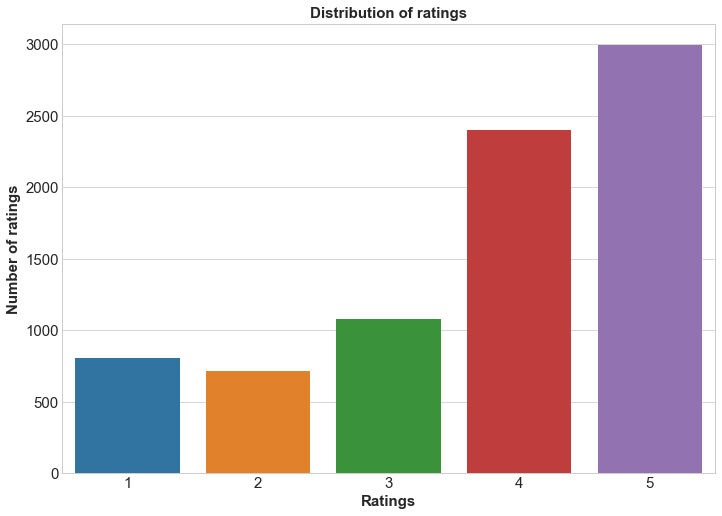

In [13]:
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
from matplotlib import pyplot
import seaborn as sns
import operator
%matplotlib inline
f = open("yelp_train_reviews.json", "r")
lines = f.readlines()
f.close()
count_stars = {}
for i in range(len(lines)):
    d = json.loads(lines[i])
    stars = d['stars']
    if stars in count_stars:
        count_stars[stars] += 1
    else:
        count_stars[stars] = 1
avg_star_count = {}
sum_stars = sum(list(count_stars.values()))
for key in count_stars.keys():
    avg_star_count[key] = count_stars[key]
years = [k for k,v in avg_star_count.items()]
values = [v for k,v in avg_star_count.items()]
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
a = sns.barplot(x=years, y=values)
a.set_title("Distribution of ratings",fontdict={'fontsize':15,'weight':'bold'})
a.set_xlabel("Ratings",fontdict={'fontsize':15,'weight':'bold'})
a.set_ylabel("Number of ratings",fontdict={'fontsize':15, 'weight':'bold'})
for label in a.get_xticklabels():
    label.set_size(15)
for label in a.get_yticklabels():
    label.set_size(15)


From the above plot, we find that the classes are heavily imbalanced(more data samples in classes - 4 and 5). So, we downsample the data to ensure equal representation from each of the classes.

Another visualization aspect was to see the distribution of the votes for the reviews. So, a review could have votes in 3 categories: "Funny review vote", "Cool review vote", "Useful review vote". The following code achieves this functionality:

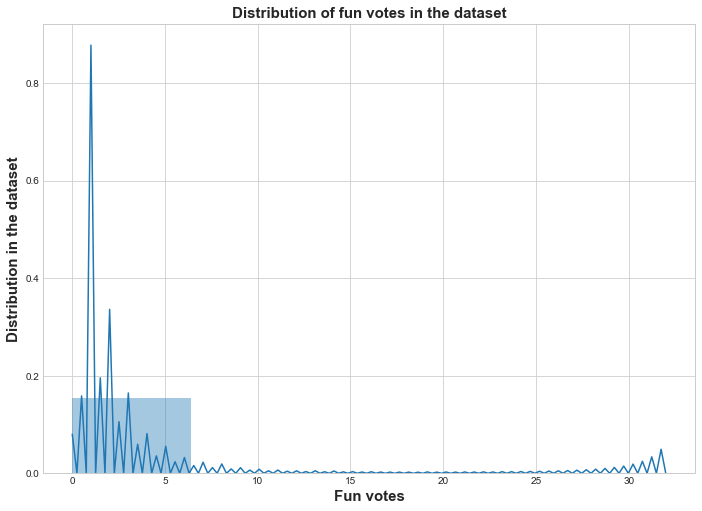

In [24]:
def plot_histogram(list_of_values, xlabel, ylabel, title):
    numbers = np.array(list_of_values).astype(np.float) 
    a4_dims = (11.7, 8.27)
    fig, ax = pyplot.subplots(figsize=a4_dims)
    a = sns.distplot(numbers, bins = 5);
    a.set_title(title,fontdict={'fontsize':15,'weight':'bold'})
    a.set_xlabel(xlabel,fontdict={'fontsize':15,'weight':'bold'})
    a.set_ylabel(ylabel,fontdict={'fontsize':15, 'weight':'bold'})
    
fun_votes = []
cool_votes = []
use_votes = []
for i in range(len(lines)):
    d = json.loads(lines[i])
    stars = d['stars']
    fun_votes.append(d['votes']['funny'])
    cool_votes.append(d['votes']['cool'])
    use_votes.append(d['votes']['useful'])

plot_histogram(fun_votes, "Fun votes", "Distribution in the dataset", "Distribution of fun votes in the dataset")


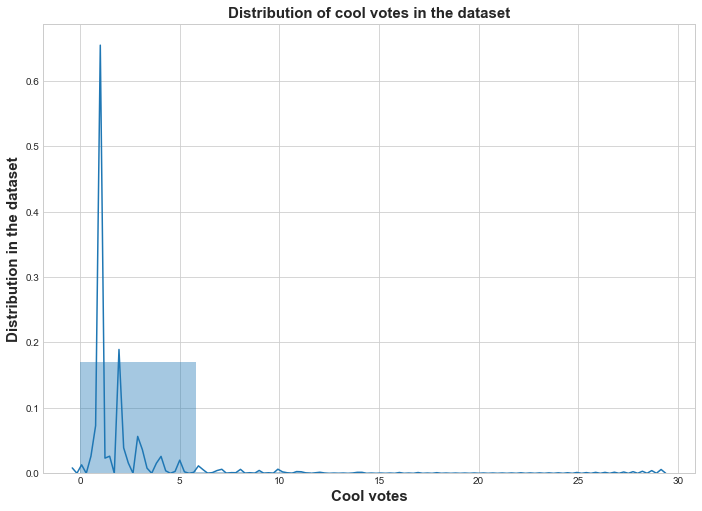

In [25]:
plot_histogram(cool_votes, "Cool votes", "Distribution in the dataset", "Distribution of cool votes in the dataset")

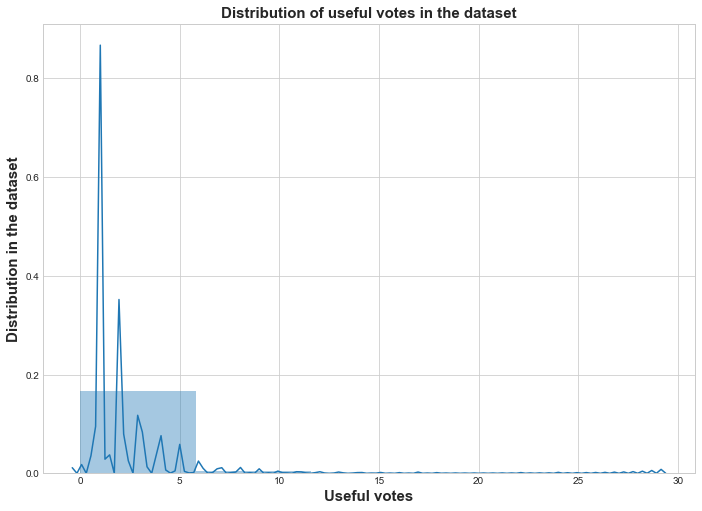

In [26]:
plot_histogram(use_votes, "Useful votes", "Distribution in the dataset", "Distribution of useful votes in the dataset")

One thing that seemed interesting to us was the distribution of average review ratings across the several years. This will provide a vague intuition as to how people were providing reviews (in turn reflecting on the quality of businesses) across years. 

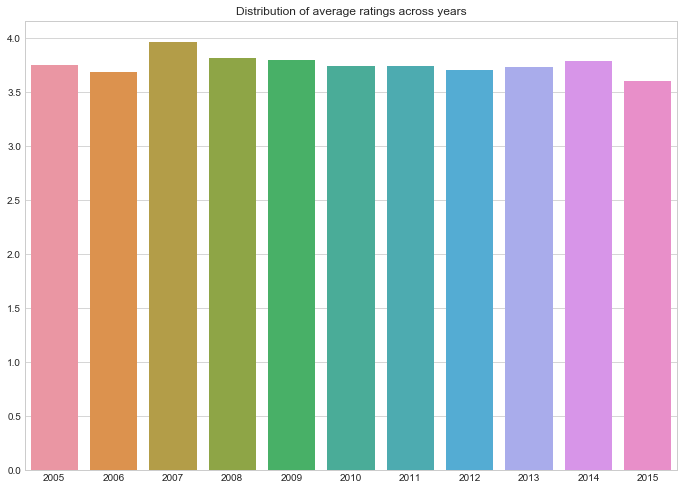

In [18]:
count_score_year = {}
count_year = {}
for i in range(len(lines)):
    d = json.loads(lines[i])
    date = datetime.strptime(d['date'], "%Y-%m-%d")
    year = date.year
    stars = d['stars']
    if year in count_score_year:
        count_score_year[year] += stars
    else:
        count_score_year[year] = stars
        
    if year in count_year:
        count_year[year] += 1
    else:
        count_year[year] = 1
final_avg_score_year = {}
for key in count_score_year.keys():
    final_avg_score_year[key] = count_score_year[key]/count_year[key]
years = [k for k,v in final_avg_score_year.items()]
values = [v for k,v in final_avg_score_year.items()]
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
a = sns.barplot(x=years, y=values).set_title("Distribution of average ratings across years")

Another fun visualization is to observe the distribution of review ratings across differnt business types. This could be slightly indicative of what business types get better reviews, which business types often need improvements, etc. The code snippet below does this:

Text(0,0.5,'Rating')

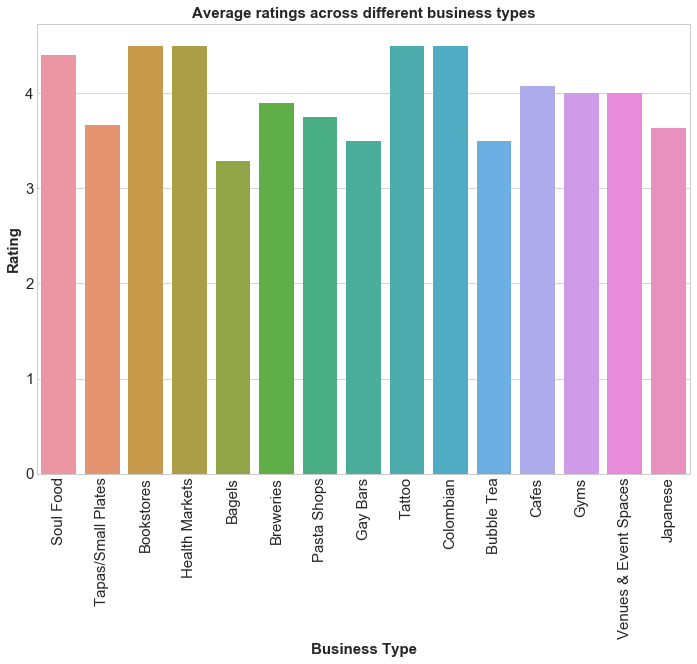

In [30]:
f = open("data.txt", "r")
lines = f.readlines()
f.close()
all_rest_info = json.loads(lines[0])
categories_sum_rating = {}
num_categories = {}

for rest in all_rest_info:
    categories = rest['categories']
    rating = rest['rating']
    for category in categories:
        title = category['title']
        if title in categories_sum_rating:
            categories_sum_rating[title] += rating
        else:
            categories_sum_rating[title] = rating
        
        if title in num_categories:
            num_categories[title] += 1
        else:
            num_categories[title] = 1

categories_avg_rating = {}
for key in categories_sum_rating.keys():
    categories_avg_rating[key] = categories_sum_rating[key]/num_categories[key]
# categories_avg_rating = sorted(categories_avg_rating.items(), key=operator.itemgetter(1), reverse = True)

years = np.array([k for k,v in categories_avg_rating.items()])
values = np.array([v for k,v in categories_avg_rating.items()])
sns.set_style("whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
index = np.random.randint(0,len(years),15)
a = sns.barplot(x=years[index], y=values[index])
for label in a.get_xticklabels():
    label.set_rotation(90)
    label.set_size(15)
for label in a.get_yticklabels():
    label.set_size(15)
a.set_title("Average ratings across different business types", fontdict={'fontsize':15,'weight':'bold'})
a.set_xlabel("Business Type", fontdict={'fontsize':15,'weight':'bold'})
a.set_ylabel("Rating",fontdict={'fontsize':15,'weight':'bold'})

Before we proceed to the part of feature extraction from the review text to be used for predicting the star rating text, we analyse if there is any direct correlation between the text and the rating. For this, we use the set of positive words like "recommended", "wonderful", "tantalizing", etc which are often used for sentiment analysis (such a dataset was obtained from http://ptrckprry.com/course/ssd/data/positive-words.txt). Specifically, we plot the number of positive words used in the review vs the ratings. And, to avoid any biases in the review texts as a result of its length, we normalize the review texts lengths. 

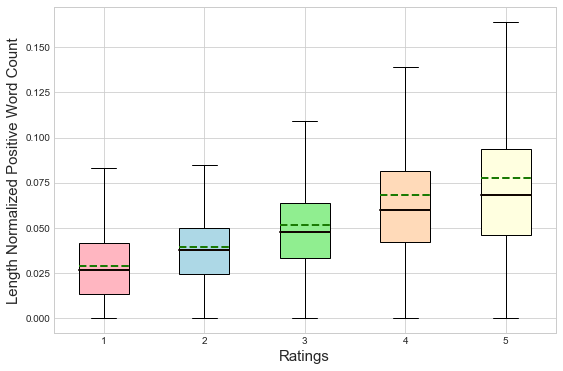

In [29]:
f = open("positive-words.txt", "r")
positive_words = f.read().strip().split('\n')
f.close()
positive_words = set(positive_words)
pos_box_plot_values = {1:[], 2:[], 3:[], 4:[], 5:[]}
for line in lines:
    d = json.loads(line)
    stars = d['stars']
    text = d['text']
    tokens = set(text.strip().lower().split())
    positive_count = len(tokens.intersection(positive_words))/len(tokens)
    pos_box_plot_values[stars].append(positive_count)
    
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(pos_box_plot_values.values(), sym='', meanline=True, showmeans=True, patch_artist=True)

box_color_values = ['lightpink', 'lightblue', 'lightgreen', 'peachpuff', 'lightyellow']

for patch, color in zip(bp['boxes'], box_color_values):
    patch.set(color='#000000', linewidth=1)
    patch.set_facecolor(color)
    
for median in bp['medians']:
    median.set(color='#110601', linewidth=2)
    
for mean in bp['means']:
    mean.set(color='#1a7a04', linewidth=2)

ax.set_xlabel('Ratings', fontdict={'fontsize':15})
ax.set_ylabel('Length Normalized Positive Word Count', fontdict={'fontsize':15})

fig.savefig('box_plot.png', bbox_inches='tight')

One striking observation that can be made from the above graph is that there is a positive correlation between the number of positive words and the star rating of that review(i.e higher number of positive words per unit word of the review text implies higher star rating). This was the main motivation behind using the review text to extract features to be used for predictions as we observe that this component in the reviews is a rich source of information that could be exploited to be used for predicting the star ratings. 

<h2><a>5. Yelp Review Rating Prediction</a></h2>
In this section, we primarily deal with feature engineering from the review text and the machine learning models used. 
<h3><a>5a. Feature Engineering</a></h3>
Since from the data exploration and visualization step we found that the review text is extremely useful in predicting the star ratings, we use 3 feature sets which are based on the text extracted from each review text. 

<b>a.) Feature Set-1:</b> We use the unigrams and bigrams(tf-idf values) from the review text as features and restrict our scope to the top 6k such features, to avoid the unimportant terms in the text. Our belief was that the top 4k-6k unigrams and bigrams are sufficiently important enough to capture the required information (based on experiments we performed by varying this parameter).<br/>
Example:<br/>
Review Text: “The whole wings and fish sandwich are good. The sides are probably the best  in Pittsburgh.”
From the above review text, we extract unigrams and bigrams.

<b>b.) Feature Set-2:</b> This feature set contains the Parts-of-Speech(POS) tags for the text.<br/> 
Example:<br/>
For the above review, the POS tagged sequence is: ('The', 'DT'), ('whole', 'JJ'), ('wings', 'NNS'), ('are', 'VBP') …. ('the', 'DT'), ('best', 'JJS'),  ('in', 'IN'), ('Pittsburgh', 'NNP')

<b>c.) Feature Set-3:</b> This feature set contains the Named-Entity-Recognizer(NER) tags for the text.<br/>
Example:<br/>
For the above review, the NER tagged sequence is: (u'The', u'O'), (u'whole', u'O'), (u'wings', u'O'), …. (u'best', u'O'), (u'in', u'O'),  (u'Pittsburgh', u'LOCATION')

The code snippet below deals with the process of feature extraction of the three sets defined above.

In [57]:
train_filename = "yelp_train_reviews.json"
dev_filename = "yelp_dev_reviews.json"

train_pos_pickle = "train_pos.pkl"
train_ner_pickle = "train_ner.pkl"

dev_pos_pickle = "dev_pos.pkl"
dev_ner_pickle = "dev_ner.pkl"

text_vectorizer_pickle = "text_vectorizer.pkl"
pos_vectorizer_pickle = "pos_vectorizer.pkl"
ner_vectorizer_pickle = "ner_vectorizer.pkl"

import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tag import StanfordNERTagger
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
def save_pickle(data, pickle_file):
    file_disc = open(pickle_file, "wb")
    pickle.dump(data, file_disc)
    file_disc.close()

def load_pickle(pickle_file):
    return pickle.load(open(pickle_file, "rb"))

def form_custom_features(train_filename, dev_filename, train_pos_pickle, train_ner_pickle, dev_pos_pickle, dev_ner_pickle, text_vectorizer_pickle, pos_vectorizer_pickle, ner_vectorizer_pickle):
    stopwords_set = set(stopwords.words('english'))
    # TF-IDF vectorizer for text
    with open(train_filename) as f:
        reviews = f.read().strip().split("\n")
    reviews = [json.loads(review) for review in reviews]
    texts = [review['text'] for review in reviews]
    stars = [int(review['stars']) for review in reviews]
    stars = np.array(stars)
    # pos_tags = compute_POS_Tags(texts)
    # save_pickle(pos_tags, train_pos_pickle)

    # ner_tags = compute_NER(texts)
    # save_pickle(ner_tags, train_ner_pickle)

    print("Forming TF-IDF vector for text")
    text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords_set, lowercase=True, max_features = 6000)
    save_pickle(text_vectorizer, text_vectorizer_pickle)
    text_vectorizer = load_pickle(text_vectorizer_pickle)

    text_vectors = text_vectorizer.fit_transform(texts).todense()
    
    pos_tags = load_pickle(train_pos_pickle)

    print("Forming TF-IDF vector for POS")
    pos_vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = stopwords_set, lowercase=True, max_features = 2000)
    save_pickle(pos_vectorizer, pos_vectorizer_pickle)
    pos_vectorizer = load_pickle(pos_vectorizer_pickle)

    pos_vectors = pos_vectorizer.fit_transform(pos_tags).todense()

    

    ner_tags = load_pickle(train_ner_pickle)

    print("Forming TF-IDF vector for NER")
    ner_vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = stopwords_set, lowercase = True, max_features=2000)
    save_pickle(ner_vectorizer, ner_vectorizer_pickle)
    ner_vectorizer = load_pickle(ner_vectorizer_pickle)

    ner_vectors = ner_vectorizer.fit_transform(ner_tags).todense()
    feat_1_train = np.array(text_vectors)
    train_vectors=np.hstack((text_vectors, pos_vectors))
    feat_2_train = np.array(train_vectors)
    train_vectors = np.array(np.hstack((train_vectors, ner_vectors)))
    feat_3_train = train_vectors
    with open(dev_filename) as f:
        reviews = f.read().strip().split("\n")
    reviews = [json.loads(review) for review in reviews]
    dev_texts = [review['text'] for review in reviews]

    # pos_tags_dev = compute_POS_Tags(dev_texts)
    # save_pickle(pos_tags_dev, dev_pos_pickle)

    # ner_tags_dev = compute_NER(dev_texts)
    # save_pickle(ner_tags_dev, dev_ner_pickle)

    dev_text_vectors = text_vectorizer.transform(dev_texts).todense()

    
    pos_tags_dev = load_pickle(dev_pos_pickle)
    dev_pos_vectors = pos_vectorizer.transform(pos_tags_dev).todense()

    
    ner_tags_dev = load_pickle(dev_ner_pickle)
    dev_ner_vectors = ner_vectorizer.transform(ner_tags_dev).todense()
    
    feat_1_dev = np.array(dev_text_vectors)
    dev_vectors = np.hstack((dev_text_vectors, dev_pos_vectors))
    feat_2_dev = np.array(dev_vectors)
    dev_vectors = np.array(np.hstack((dev_vectors, dev_ner_vectors)))
    feat_3_dev = dev_vectors

    print("Feature extraction - Done!")
#     return train_vectors, stars, dev_vectors
    return feat_1_train, feat_2_train, feat_3_train, stars, feat_1_dev, feat_2_dev, feat_3_dev

custom_train_feat_1, custom_train_feat_2, custom_train_feat_3, y_train, custom_dev_feat_1, custom_dev_feat_2,custom_dev_feat_3 = form_custom_features(train_filename, dev_filename, train_pos_pickle, train_ner_pickle, dev_pos_pickle, dev_ner_pickle, text_vectorizer_pickle, pos_vectorizer_pickle, ner_vectorizer_pickle) 


Forming TF-IDF vector for text
Forming TF-IDF vector for POS
Forming TF-IDF vector for NER
Feature extraction - Done!


<h3><a>5b. Machine Learning Models</a></h3>
Since we formulate the problem as a 'Multi-Class Classification' Problem, we use the standard classification techniques in Machine learning to tackle this. More specifically, we evaluated using the following 4 ML models:

<b>a.) Logistic Regression:</b><br/>
Multinomial logistic regression is a classification method that generalizes logistic regression to multiclass problems, i.e. with more than two possible discrete outcomes. That is, it is a model that is used to predict the probabilities of the different possible outcomes of a categorically distributed dependent variable, given a set of independent variables (which may be real-valued, binary-valued, categorical-valued, etc.). In our case, the independent variables are the feeature vectors defined earlier. 

We implemented the Multi-Class Logistic Regression as below from scratch without using the Python sklearn's inbuilt functionality. 

In [59]:
def predict(x_dev_matrix, W):
    term_1 = np.exp(x_dev_matrix.dot(W))
    predictions = term_1/(np.sum(term_1, axis=1)[:, np.newaxis])
    # hard predictions
    hard_predictions = np.argmax(predictions, axis=1)+1
    return hard_predictions

def mini_batch_logistic_solver(x_train, y_train, lambda_val):
    y_train = np.array(y_train)
#     print(y_train.shape, x_train.shape)
    num_training_samples = x_train.shape[0]
    y_train_matrix = np.zeros((num_training_samples, 5))
    for i in range(y_train.shape[0]):
        y_train_matrix[i][y_train[i]-1] = 1
    dim = x_train.shape[1]
    w = np.zeros((dim, 5))
    x_train_temp = x_train
    y_train_temp = y_train_matrix
    batch_size = 16
    max_epochs = 100
    eta = 0.01
    beta = 0.001
    num_training_samples = x_train_temp.shape[0]
    num_batches = int(num_training_samples/batch_size)
    print("num batches:", num_batches)
    for curr_epoch in range(max_epochs):
        shuffle_idx = np.arange(num_training_samples)
        np.random.shuffle(shuffle_idx)
        x_train_temp = x_train_temp[shuffle_idx]
        y_train_temp = y_train_temp[shuffle_idx]
        if(curr_epoch%50==0):
            print('epoch:',curr_epoch+1)
        for curr_batch in range(num_batches+1):
            if(curr_batch==num_batches):
                x_train_batch = x_train_temp[curr_batch*batch_size:num_training_samples,:]
                y_train_batch = y_train_temp[curr_batch*batch_size:num_training_samples,:]
            else:
                x_train_batch = x_train_temp[curr_batch*batch_size: (curr_batch+1)*batch_size,:]
                y_train_batch = y_train_temp[curr_batch*batch_size: (curr_batch+1)*batch_size,:]
            term_1 = np.exp(x_train_batch.dot(w))
            gradient = x_train_batch.T.dot(y_train_batch - term_1/np.sum(term_1, axis=1)[:, np.newaxis]) - lambda_val*w
            w = w+eta*gradient
    return w
W_custom_1 = mini_batch_logistic_solver(custom_train_feat_1, y_train, 0.001)
logistic_regression_predictions_feat_1 = predict(custom_dev_feat_1, W_custom_1)

W_custom_2 = mini_batch_logistic_solver(custom_train_feat_2, y_train, 0.001)
logistic_regression_predictions_feat_2 = predict(custom_dev_feat_2, W_custom_2)

W_custom_3 = mini_batch_logistic_solver(custom_train_feat_3, y_train, 0.001)
logistic_regression_predictions_feat_3 = predict(custom_dev_feat_3, W_custom_3)


y_dev = []
with open(dev_filename, "r") as file:
    lines = file.read().splitlines();
    for line in lines:
        curr_review = json.loads(line)
        curr_review_stars = int(curr_review['stars'])
        y_dev.append(curr_review_stars)
y_dev = np.array(y_dev)
print("Logistic Regression Accuracy on split dev using {Feature Set-1}:", accuracy_score(y_dev, logistic_regression_predictions_feat_1))
print("Logistic Regression Accuracy on split dev using {Feature Set-1, Feature Set-2}:", accuracy_score(y_dev, logistic_regression_predictions_feat_2))
print("Logistic Regression Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}:", accuracy_score(y_dev, logistic_regression_predictions_feat_3))

num batches: 500
epoch: 1
epoch: 51
num batches: 500
epoch: 1
epoch: 51
num batches: 500
epoch: 1
epoch: 51
Logistic Regression Accuracy on split dev using {Feature Set-1}: 0.595
Logistic Regression Accuracy on split dev using {Feature Set-1, Feature Set-2}: 0.5725
Logistic Regression Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}: 0.5775


<b>b.) Support Vector Machines(SVMs):</b><br/>
Support Vector Machines (SVMs) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. The multiclass support is handled according to a one-vs-one scheme.(Python's sklearn was used for this model) 


In [60]:
# SVM multi-class
from sklearn import svm
clf_1 = svm.SVC(decision_function_shape='ovo', kernel='linear')
clf_1.fit(custom_train_feat_1, y_train)
predictions_1 = clf_1.predict(custom_dev_feat_1)
print("SVM Accuracy on split dev using {Feature Set-1}:", accuracy_score(y_dev, predictions_1))
clf_2 = svm.SVC(decision_function_shape='ovo', kernel='linear')
clf_2.fit(custom_train_feat_2, y_train)
predictions_2 = clf_2.predict(custom_dev_feat_2)
print("SVM Accuracy on split dev using {Feature Set-1, Feature Set-2}:", accuracy_score(y_dev, predictions_2))
clf_3 = svm.SVC(decision_function_shape='ovo', kernel='linear')
clf_3.fit(custom_train_feat_3, y_train)
predictions_3 = clf_3.predict(custom_dev_feat_3)
print("SVM Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}:", accuracy_score(y_dev, predictions_3))

SVM Accuracy on split dev using {Feature Set-1}: 0.5725
SVM Accuracy on split dev using {Feature Set-1, Feature Set-2}: 0.5875
SVM Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}: 0.58


<b>c.) Random Forest Classifier:</b><br/>
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.(Python's sklearn was used for this model) 

In [61]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_1 = RandomForestClassifier(n_estimators=500, max_depth=500)
clf_1.fit(custom_train_feat_1, y_train)
predictions_1 = clf_1.predict(custom_dev_feat_1)
# print(predictions)
print("RF Accuracy on split dev using {Feature Set-1}:", accuracy_score(y_dev, predictions_1))

clf_2 = RandomForestClassifier(n_estimators=500, max_depth=500)
clf_2.fit(custom_train_feat_2, y_train)
predictions_2 = clf_2.predict(custom_dev_feat_2)
# print(predictions)
print("RF Accuracy on split dev using {Feature Set-1, Feature Set-2}:", accuracy_score(y_dev, predictions_2))

clf_3 = RandomForestClassifier(n_estimators=500, max_depth=500)
clf_3.fit(custom_train_feat_3, y_train)
predictions_3 = clf_3.predict(custom_dev_feat_3)
# print(predictions)
print("RF Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}:", accuracy_score(y_dev, predictions_3))

RF Accuracy on split dev using {Feature Set-1}: 0.53
RF Accuracy on split dev using {Feature Set-1, Feature Set-2}: 0.4725
RF Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}: 0.455


<b>d.) Neural Networks - Multi Layer Perceptron(MLP):</b><br/>
A multilayer perceptron (MLP) is a class of feedforward artificial neural network. An MLP consists of at least three layers of nodes. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable. Multilayer perceptrons are sometimes colloquially referred to as "vanilla" neural networks, especially when they have a single hidden layer.(Python's sklearn was used for this model) 

In [67]:
# Neural Nets
from sklearn.neural_network import MLPClassifier
clf_1 = MLPClassifier(hidden_layer_sizes=(3000, 1000, 500, 200,), max_iter = 100)
clf_1.fit(custom_train_feat_1, y_train)
predictions_1 = clf_1.predict(custom_dev_feat_1)
# print(predictions)
print("MLP Accuracy on split dev using {Feature Set-1}:", accuracy_score(y_dev, predictions_1))

clf_2 = MLPClassifier(hidden_layer_sizes=(3000, 1000, 500, 200,), max_iter = 100)
clf_2.fit(custom_train_feat_2, y_train)
predictions_2 = clf_2.predict(custom_dev_feat_2)
# print(predictions)
print("MLP Accuracy on split dev using {Feature Set-1, Feature Set-2}:", accuracy_score(y_dev, predictions_2))

clf_3 = MLPClassifier(hidden_layer_sizes=(3000, 1000, 500, 200,), max_iter = 100)
clf_3.fit(custom_train_feat_3, y_train)
predictions_3 = clf_3.predict(custom_dev_feat_3)
# print(predictions)
print("MLP Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}:", accuracy_score(y_dev, predictions_3))

MLP Accuracy on split dev using {Feature Set-1}: 0.555
MLP Accuracy on split dev using {Feature Set-1, Feature Set-2}: 0.56
MLP Accuracy on split dev using {Feature Set-1, Feature Set-2, Feature Set-3}: 0.54


<h3><a>5c. Evaluation Metrics</a></h3>
Our problem, being a 'multi-class classification', it makes sense to use "Accuracy" as out primary evaluation metric. In our case, it is defined as: the percentage of correctly classified classes(where each class is a star rating). 
Also, we could have reported the "Root Mean Square Error(RMSE)" values but since RMSE is usually deemed fit for regression tasks, we donot report the RMSE values, but choose "Accuracy" instead.

<h2><a>6. Results</a></h2>
<p>The baseline for our task is 20%(obtained by predicting any one of the classes out of the 5 available classes randomly). The %Accuracy values obtained for the other Machine Learning models is provided in the table below. We perform the experimentation as follows: For each ML model, we run three experiments: one with Feature Set-1, another with both Feature Sets 1 & 2, finally with Feature Sets-1, 2 & 3. The results in each of those cases has been summarized in the following table:  </p>
<table>
        <tr>
            <th style="font-size:16px;text-align:center" rowspan=2><b>Model</b></th>
            <th style="font-size:16px;text-align:center" colspan=3><b>Accuracy(in %)</b></th> 
        </tr>
        <tr>
            <th style="font-size:16px;text-align:center"><b>Feature Set 1</b></th>
            <th style="font-size:16px;text-align:center"><b>Feature Set 1 & 2</b></th>
            <th style="font-size:16px;text-align:center"><b>Feature Set 1, 2 & 3</b></th>
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Random Baseline</td>
            <td style="font-size:14px;text-align:center">20.00</td>  
            <td style="font-size:14px;text-align:center">20.00</td> 
            <td style="font-size:14px;text-align:center">20.00</td> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Logistic Regression</td>
            <td style="font-size:14px;text-align:center"><b>59.50</b></td>
            <td style="font-size:14px;text-align:center">57.25</td> 
            <td style="font-size:14px;text-align:center">57.75</td> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Support Vector Machine(linear kernel)</td>
            <td style="font-size:14px;text-align:center">57.25</td>
            <td style="font-size:14px;text-align:center">58.75</td> 
            <td style="font-size:14px;text-align:center">58.00</td> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Random Forest</td>
            <td style="font-size:14px;text-align:center">53.00</td>
            <td style="font-size:14px;text-align:center">47.25</td> 
            <td style="font-size:14px;text-align:center">45.50</td> 
        </tr>
        <tr>
            <td style="font-size:14px;text-align:center">Neural Networks(MLP)</td>
            <td style="font-size:14px;text-align:center">55.50</td>
            <td style="font-size:14px;text-align:center">56.00</td> 
            <td style="font-size:14px;text-align:center">54.00</td> 
        </tr>
    </table>

From the results above, we find that Logistic Regression with only the text-based features(i.e Feature Set-1) performs the best with an accuracy of 59.50%. Further addition of features might not be helping the models as there could be no correlation between these features and the star ratings.(Maybe by further parameter tuning and better neural architecture, we could beat the other models, but that would be more time consuming and tedious)

<h2><a>7. References</a></h2>
1. [Mingming Fan and Maryam Khademi. 2014. Predicting a Business Star in Yelp from Its Reviews Text Alone.](https://arxiv.org/abs/1401.0864)
2. [Clayton J Huo and Eric Gilbert. 2014. Vader: A parsimonious rule-based model for sentiment analysis of social media text.](https://pdfs.semanticscholar.org/a6e4/a2532510369b8f55c68f049ff11a892fefeb.pdf)
3. [Julian McAuley and Jure Leskovec. 2013. Hidden Factors and Hidden Topics: Understanding Rating Dimensions with Review Text.](http://i.stanford.edu/~julian/pdfs/recsys_extended.pdf)
4. [Juan Ramos and others. 2003. Using tf-idf to determine word relevance in document queries.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.121.1424&rep=rep1&type=pdf)
5. [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge)
6. [Beautiful Soup Documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
7. [Seaborn: Statistical Data Visualization](https://seaborn.pydata.org/)
8. [Stanford NER Tagging](https://nlp.stanford.edu/software/CRF-NER.shtml)